## Python Data fitting with various functions - HW 12
Due Monday Dec 1, 2025



Dowload the data "miniDR17.fits" from the TCU Online Week 14:<br>
<i>NOTE: it is a large-ish file and may take a while.</i>

**However, this is a small version of the full science data file (4 GB) which can be found at:**<br>
https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits


My example below will show how to remove Identified bad data, 
however data that are just bad in one quantity may remain

_Use masking to remove any remaining bad values (typically 9999 or -9999 in this file_ , <b>but check!!!! If you are not sure, ask!!!</b>). 

In [66]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d


# Monte Carlo-version of 2 parameter Curve Fit that can use BOTH x and Y errors
def mcFit2(func, x, y, x_err=0.1, y_err=0.1, p0=[0,0]):
    slope = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])
    return (np.median(slope),np.median(y_ints))


# Monte Carlo-version of 3 parameter Curve Fit that can use BOTH x and Y errors
def mcFit3(func, x, y, x_err=0.1, y_err=0.1,p0=[1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
    return (np.median(paramA),np.median(paramB),np.median(paramC))

# Monte Carlo-version of 4 parameter Curve Fit that can use BOTH x and Y errors
def mcFit4(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1,1,1], bounds=(-np.inf, np.inf), maxfev = 20000):
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0, bounds=bounds, maxfev=maxfev)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])
    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))


In [67]:
# READ IN FITS FILES
star_hdus = fits.open('miniDR17.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'TEFF'; format = 'E'
    name = 'TEFF_ERR'; format = 'E'
    name = 'LOGG'; format = 'E'
    name = 'LOGG_ERR'; format = 'E'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'SNR'; format = 'E'
    name = 'VHELIO_AVG'; format = 'E'
    name = 'VERR'; format = 'E'
    name = 'FE_H'; format = 'E'
    name = 'FE_H_ERR'; format = 'E'
    name = 'O_FE'; format = 'E'
    name = 'O_FE_ERR'; format = 'E'
    name = 'NI_FE'; format = 'E'
    name = 'NI_FE_ERR'; format = 'E'
    name = 'NVISITS'; format = 'J'
    name = 'VSCATTER'; format = 'E'
    name = 'ASPCAPFLAG'; format = 'K'
    name = 'STARFLAG'; format = 'K'
    name = 'EXTRATARG'; format = 'J'
    name = 'GAIA_PARALLAX'; format = 'E'
    name = 'GAIA_PARALLAX_ERROR'; for

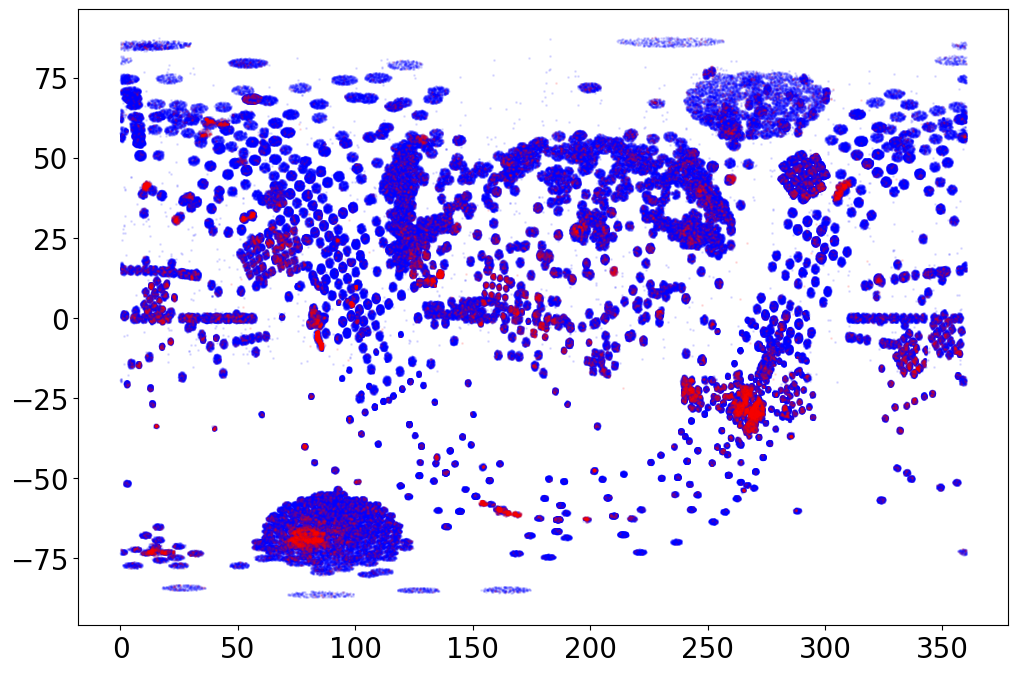

In [68]:
# TWO BITWISE FLAGS FOR BAD DATA - THESE REMOVE IDENTIFIED BAD DATA            
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
bd = (np.bitwise_and(star['aspcapflag'], badbits) != 0) |\
     (np.bitwise_and(star['starflag'], suspectbits) != 0) 

good = np.where(gd)[0]
bad = np.where(bd)[0]

# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(star['RA'][good],star['DEC'][good],s=1,c='b',alpha=0.1)
ax.scatter(star['RA'][bad],star['DEC'][bad],s=1,c='r',alpha=0.1)


ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.show()

LINEAR: -0.074, 16.223
POLY2: 0.005, -1.877, 130.634
COSFIT: 61.000, 0.019, -0.507, -5.000


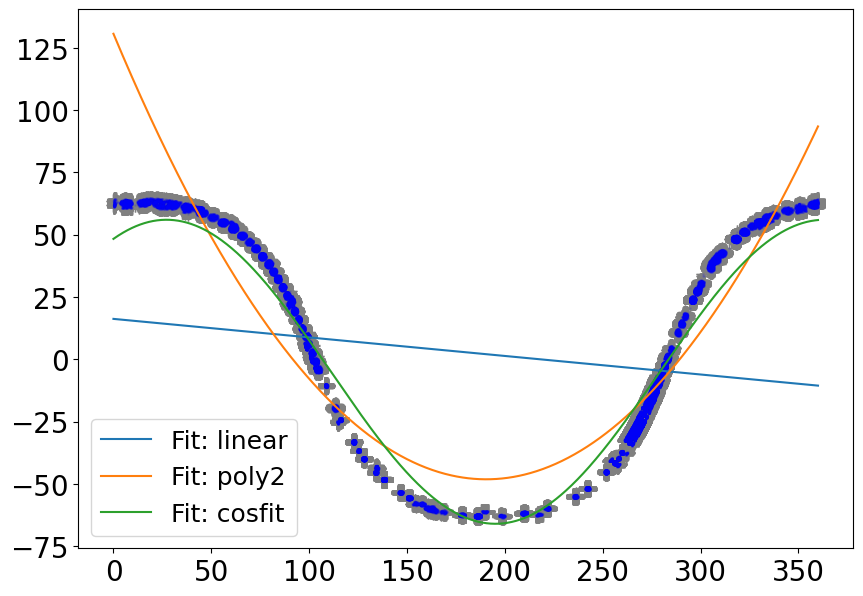

In [69]:
# EXAMPLE FIT - DR. FRINCHABOY
# --------------------------------------------
# First use Linear, Polnomial, and Cosine Fits
# Select stars only with with  −2 < GLAT < 2   
# 
# I FIT RA & DEC data versus LINEAR, POLY2, AND COSFIT in this example.  
#
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolean Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct0 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] < 2) &\
     (star['GLAT'] > -2) 
cut0 = np.where(ct0)[0]
bounds = (
    [59, -5, -10, -5],
    [61, 5, 10, 5]
)
maxfev = 2000
#=================================================================================
## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['RA'][cut0], star['DEC'][cut0], 0.001, \
                          0.001, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['RA'][cut0], star['DEC'][cut0], 0.001, \
                         0.001,p0=[600,1,1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
## COS FIT (4 parameter)
cfA, cfB, cfC, cfD = mcFit4(cosfit, star['RA'][cut0], star['DEC'][cut0], 0.001, \
                            0.001,p0=[60,0.02,0,0], bounds = bounds, maxfev = maxfev)
print(f'COSFIT: {cfA:.3f}, {cfB:.3f}, {cfC:.3f}, {cfD:.3f}')
#=================================================================================



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig0 = plt.figure(figsize=(10,7))
ax0 = fig0.add_subplot(111)
ax0.xaxis.set_tick_params(labelsize=20)
ax0.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax0.scatter(star['RA'][cut0],star['DEC'][cut0],s=1,c='b',alpha=0.1)
ax0.errorbar((star['RA'][cut0]),star['DEC'][cut0], xerr=(0.001),
             yerr=(0.001), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(0,360,1000) # X-PLOTING FOR FITS

#=================================================================================
#linear fit
ax0.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax0.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#cosfit
ax0.plot(x_plot,cosfit(x_plot, cfA, cfB, cfC, cfD), label='Fit: cosfit')

plt.legend(loc='best', fontsize=18)
plt.show()

# Homework #12

**REMINDER:** *All coding assignment will be turned in as .ipynb files, to the same PHYS_X0223 repository on GitHub.*   
*They should be turned in with the following naming:*
    
    Lastname_Firstinitial_24_HW12a.ipynb

## DATA FIT 1

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
1. Select stars only with with $ GLAT > 20$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -0.216, 0.058
POLY2: -0.048, -0.269, 0.055
POLY3:  0.077,  0.119, -0.220,  0.049


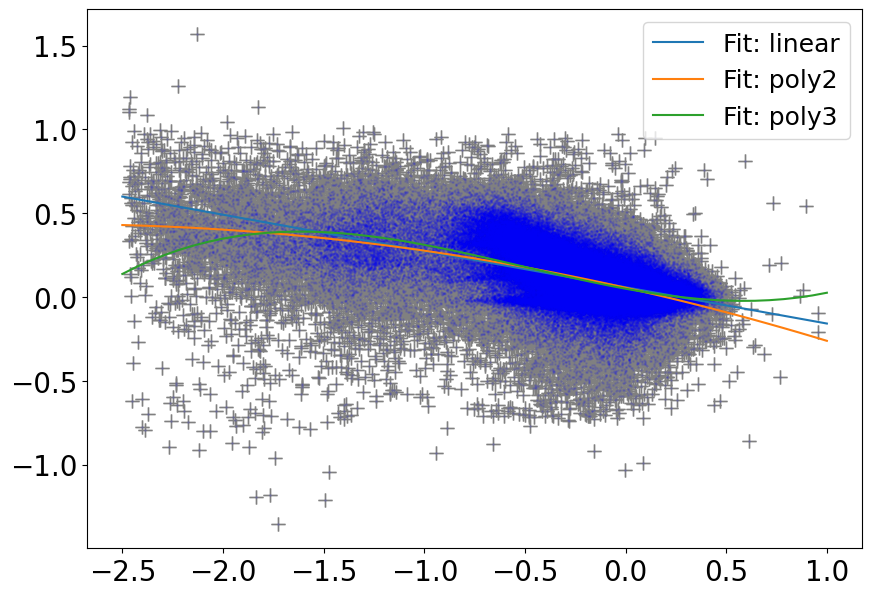

1. The best fit parameters seem to be roughly 10 or 20
2. For this function, they all seem to fit the data pretty well


In [70]:

# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolean Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      (star['GLAT'] > 20) & \
      np.isfinite(star['FE_H']) & np.isfinite(star['O_FE']) &\
      np.isfinite(star['FE_H_ERR']) & np.isfinite(star['O_FE_ERR'])
cut1 = np.where(ct1)[0]
bounds = (
    [59, -5, -10, -5],
    [61, 5, 10, 5]
)
maxfev = 2000


#=================================================================================
## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['FE_H'][cut1], star['O_FE'][cut1], 0.1, \
                          0.1, p0=[10,10])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['FE_H'][cut1], star['O_FE'][cut1], 0.1, \
                         0.1,p0=[600,10,10])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
## COS FIT (4 parameter)
#cfA, cfB, cfC, cfD = mcFit4(cosfit, star['FE_H'][cut1], star['O_FE'][cut1], 0.1, \
                            #0.1,p0=[60,10,20,20])
#print(f'COSFIT: {cfA:.3f}, {cfB:.3f}, {cfC:.3f}, {cfD:.3f}')
#=================================================================================
#Poly 3 fit
threeA, threeB, threeC, threeD = mcFit4(poly3, star['FE_H'][cut1], star['O_FE'][cut1], 0.1, 0.1, p0 = [50, 10, 10, 10])
print(f'POLY3: {threeA: .3f}, {threeB: .3f}, {threeC: .3f}, {threeD: .3f}')



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['FE_H'][cut1],star['O_FE'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['FE_H'][cut1]),star['O_FE'][cut1], 'FE_H_ERR'==(0.1),
             'O_FE_ERR'==(0.1), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(-2.5,1,50) # X-PLOTING FOR FITS

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#cosfit
ax1.plot(x_plot,poly3(x_plot, threeA, threeB, threeC, threeD), label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.show()

print('1. The best fit parameters seem to be roughly 10 or 20')
print('2. For this function, they all seem to fit the data pretty well')

## DATA FIT 2

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
2. Select stars only with with $-1< GLAT < 1$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -0.123, 0.042
POLY2: -0.008, -0.127, 0.042
POLY3:  0.077,  0.110, -0.121,  0.034


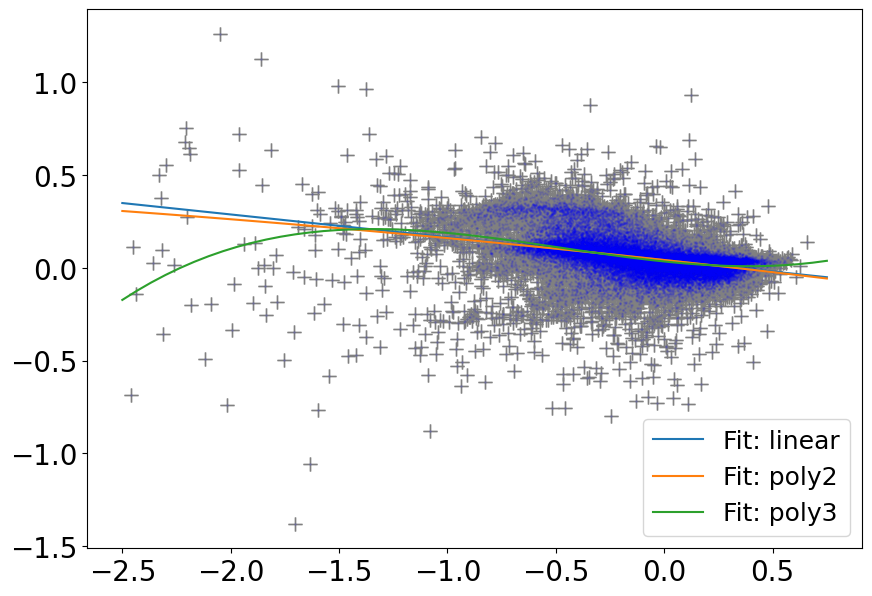

1. For this function most of the best guesses are also around 10, but I've been using larger numbers for some of the first variables
2. This one also works well with all three fits.


In [71]:

# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolean Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct2 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      (star['GLAT'] > -1) & \
      (star['GLAT'] < 1) & \
      np.isfinite(star['FE_H']) & np.isfinite(star['O_FE']) &\
      np.isfinite(star['FE_H_ERR']) & np.isfinite(star['O_FE_ERR'])
cut2 = np.where(ct2)[0]



#=================================================================================
## LINEAR FIT (2 parameter)
slope2, intercept2 = mcFit2(linear, star['FE_H'][cut2], star['O_FE'][cut2], 0.1, \
                          0.1, p0=[10,10])
print(f'LINEAR: {slope2:.3f}, {intercept2:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
polyA2, polyB2, polyC2,  = mcFit3(poly2, star['FE_H'][cut2], star['O_FE'][cut2], 0.1, \
                         0.1,p0=[600,10,10])
print(f'POLY2: {polyA2:.3f}, {polyB2:.3f}, {polyC2:.3f}')

#=================================================================================
## COS FIT (4 parameter)
#cfA, cfB, cfC, cfD = mcFit4(cosfit, star['FE_H'][cut1], star['O_FE'][cut1], 0.1, \
                            #0.1,p0=[60,10,20,20])
#print(f'COSFIT: {cfA:.3f}, {cfB:.3f}, {cfC:.3f}, {cfD:.3f}')
#=================================================================================
#Poly 3 fit
threeA2, threeB2, threeC2, threeD2 = mcFit4(poly3, star['FE_H'][cut2], star['O_FE'][cut2], 0.1, 0.1, p0 = [50, 10, 10, 10])
print(f'POLY3: {threeA2: .3f}, {threeB2: .3f}, {threeC2: .3f}, {threeD2: .3f}')



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot(111)
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax2.scatter(star['FE_H'][cut2],star['O_FE'][cut2],s=1,c='b',alpha=0.1)
ax2.errorbar((star['FE_H'][cut2]),star['O_FE'][cut2], 'FE_H_ERR'==(0.1),
             'O_FE_ERR'==(0.1), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot2 = np.linspace(-2.5,0.75,50) # X-PLOTING FOR FITS

#=================================================================================
#linear fit
ax2.plot(x_plot2,linear(x_plot2, slope2, intercept2), label='Fit: linear')
#poly2 fit
ax2.plot(x_plot2,poly2(x_plot2, polyA2, polyB2, polyC2), label='Fit: poly2')
#poly3 fit
ax2.plot(x_plot2,poly3(x_plot2, threeA2, threeB2, threeC2, threeD2), label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.show()

print("1. For this function most of the best guesses are also around 10, but I've been using larger numbers for some of the first variables")
print('2. This one also works well with all three fits.')

## DATA FIT 3

Fit a linear, polynomial (poly3), and a exponetial functions and to the following selections of the data:
3. Select stars only with with $340 < GLON < 360$ <br>
   __Fit TEFF,  (TEFF\_ERR)  vs.  LOGG (LOGG\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: 0.000, 0.348
POLY3:  0.000, -0.000,  0.002, -4.058
EXPONENTIAL: -7.894, -0.000,  0.332,  4.732


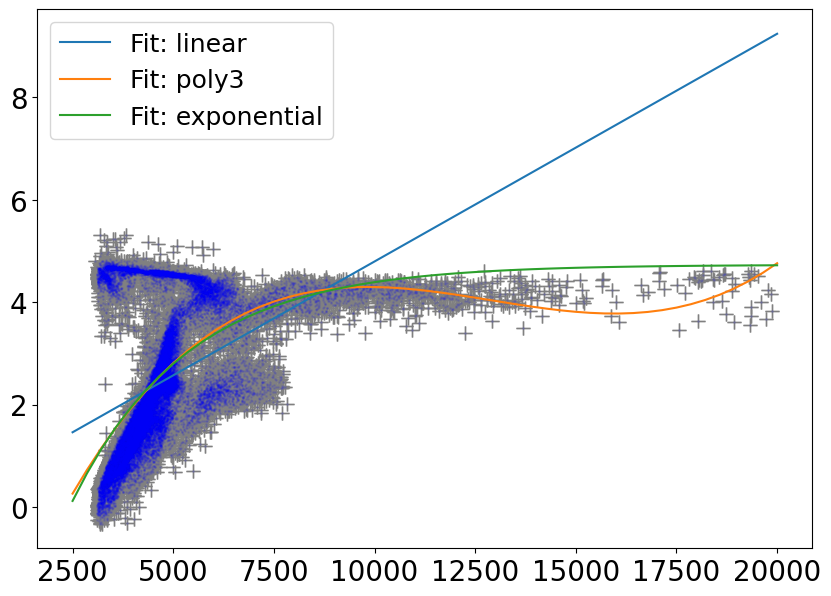

1. I had trouble figuring out what parameters to use for these; no matter how high I made the slopes, they always seemed too shallow.
2. The exponential function seems to fit this pretty well. I think the poly3 would be okay too, but when I was trying to make the first half
steeper I think I accidentally made the second half curvier so it's not as in line anymore.


In [72]:
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolean Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct3 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      (star['GLON'] > 340) & \
      (star['GLON'] < 360) & \
      np.isfinite(star['TEFF']) & np.isfinite(star['LOGG']) &\
      np.isfinite(star['TEFF_ERR']) & np.isfinite(star['LOGG_ERR'])
cut3 = np.where(ct3)[0]
bounds = (
    [-10, -5, -10, -5],
    [10, 5, 10, 5]
)
maxfev = 2000


#=================================================================================
## LINEAR FIT (2 parameter)
slope3, intercept3 = mcFit2(linear, star['TEFF'][cut3], star['LOGG'][cut3], 0.1, \
                          0.1, p0=[500,-1])
print(f'LINEAR: {slope3:.3f}, {intercept3:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
#polyA, polyB, polyC,  = mcFit3(poly2, star['TEFF'][cut1], star['LOGG'][cut1], 0.1, \
                       #  0.1,p0=[600,10,10])
#print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
## COS FIT (4 parameter)
#cfA, cfB, cfC, cfD = mcFit4(cosfit, star['FE_H'][cut1], star['O_FE'][cut1], 0.1, \
                            #0.1,p0=[60,10,20,20])
#print(f'COSFIT: {cfA:.3f}, {cfB:.3f}, {cfC:.3f}, {cfD:.3f}')

#=================================================================================
#Poly 3 fit
threeA3, threeB3, threeC3, threeD3 = mcFit4(poly3, star['TEFF'][cut3], star['LOGG'][cut3], 0.1, 0.1, p0 = [10, 10, 1, -4])
print(f'POLY3: {threeA3: .3f}, {threeB3: .3f}, {threeC3: .3f}, {threeD3: .3f}')

#===================================================================================
#exponential fit
exA3, exB3, exC3, exD3 = mcFit4(exponential, (star['TEFF'][cut3]), (star['LOGG'][cut3]), 0.1, 0.1, p0 = [-9, 0, 1, 3.67], bounds = bounds, maxfev = maxfev)
print(f'EXPONENTIAL: {exA3: .3f}, {exB3: .3f}, {exC3: .3f}, {exD3: .3f}')



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig3 = plt.figure(figsize=(10,7))
ax3 = fig3.add_subplot(111)
ax3.xaxis.set_tick_params(labelsize=20)
ax3.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax3.scatter(star['TEFF'][cut3],star['LOGG'][cut3],s=1,c='b',alpha=0.1)
ax3.errorbar((star['TEFF'][cut3]),star['LOGG'][cut3], 'TEFF_ERR'==(0.1),
             'LOGG_ERR'==(0.1), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot3 = np.linspace(2500,20000,50) # X-PLOTING FOR FITS

#=================================================================================
#linear fit
ax3.plot(x_plot3,linear(x_plot3, slope3, intercept3), label='Fit: linear')
#poly3 fit
ax3.plot(x_plot3,poly3(x_plot3, threeA3, threeB3, threeC3, threeD3), label='Fit: poly3')
#exponential fit
ax3.plot(x_plot3,exponential(x_plot3, exA3, exB3, exC3, exD3), label='Fit: exponential')

plt.legend(loc='best', fontsize=18)
plt.show()

print('1. I had trouble figuring out what parameters to use for these; no matter how high I made the slopes, they always seemed too shallow.')
print('2. The exponential function seems to fit this pretty well. I think the poly3 would be okay too, but when I was trying to make the first half')
print("steeper I think I accidentally made the second half curvier so it's not as in line anymore.")

## DATA FIT 4

Fit  a linear, a exponential, and a polynomial (poly2) functions and to the following selections of the data:
4. Select stars only with with $DEC < -50$ and $50 < RA < 120$ <br>
   __Fit TEFF,  (TEFF\_ERR)   vs.  (star['J'] - star['K']) (JK_ERR)__<br>
<br>
<b>NOTE: you will have to create a (J-K) error:</b>  JK_ERR = np.sqrt( J\_ERR^2 + K\_ERR^2 )<br> 

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -0.000, 1.538
POLY2: 0.000, -0.001, 2.692
EXPONENTIAL:  1.089, -0.382,  1.600, -0.109


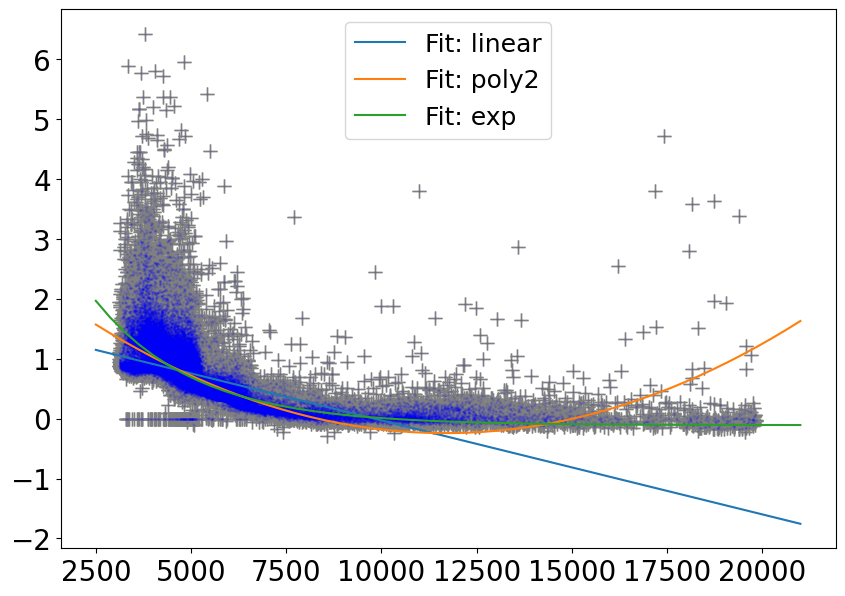

1. For this fit, most of the best parameters were decimals.
2. The exponential function also seems to work best for this one.


In [73]:
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolean Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct4 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      (star['DEC'] < 50) & \
      (star['RA'] > 50) & \
      (star['RA'] < 120) & \
      np.isfinite(star['TEFF']) & np.isfinite(star['K_ERR']) &\
      np.isfinite(star['TEFF_ERR']) & np.isfinite(star['J_ERR'])
cut4 = np.where(ct4)[0]
JK = star['J'][cut4] - star['K'][cut4]
JK_ERR = np.sqrt((star['J_ERR'][cut4]**2) + (star['K_ERR'][cut4]**2))
TEFF_scaled = star['TEFF'][cut4]/1000
TEFF_ERR_scaled = star['TEFF_ERR'][cut4]/1000
bounds = (
    [0, -5, -10, -5],
    [5, 5, 10, 5]
)

#=================================================================================
## LINEAR FIT (2 parameter)
slope4, intercept4 = mcFit2(linear, star['TEFF'][cut4], JK ,star['TEFF_ERR'][cut4] , \
                          JK_ERR, p0=[-0.005,2])
print(f'LINEAR: {slope4:.3f}, {intercept4:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
polyA4, polyB4, polyC4,  = mcFit3(poly2, (star['TEFF'][cut4]), JK, star['TEFF_ERR'][cut4], \
                         JK_ERR,p0=[4,0.5,1])
print(f'POLY2: {polyA4:.3f}, {polyB4:.3f}, {polyC4:.3f}')

#=================================================================================
## COS FIT (4 parameter)
#cfA, cfB, cfC, cfD = mcFit4(cosfit, star['FE_H'][cut1], star['O_FE'][cut1], 0.1, \
                            #0.1,p0=[60,10,20,20])
#print(f'COSFIT: {cfA:.3f}, {cfB:.3f}, {cfC:.3f}, {cfD:.3f}')
#=================================================================================
#Poly 3 fit
#threeA, threeB, threeC, threeD = mcFit4(poly3, star['FE_H'][cut1], star['O_FE'][cut1], 0.1, 0.1, p0 = [50, 10, 10, 10])
#print(f'POLY3: {threeA: .3f}, {threeB: .3f}, {threeC: .3f}, {threeD: .3f}')

#===================================================================================
#exponential fit
exA4, exB4, exC4, exD4 = mcFit4(exponential, TEFF_scaled, (JK), TEFF_ERR_scaled, JK_ERR, p0 = [.5, -0.2, 0.1, 0.5], bounds = bounds, maxfev = 20000)
print(f'EXPONENTIAL: {exA4: .3f}, {exB4: .3f}, {exC4: .3f}, {exD4: .3f}')


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax4 = fig1.add_subplot(111)
ax4.xaxis.set_tick_params(labelsize=20)
ax4.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax4.scatter(star['TEFF'][cut4],JK,s=1,c='b',alpha=0.1)
ax4.errorbar((star['TEFF'][cut4]),JK, 'TEFF_ERR'==(0.1),
             'JK_ERR'==(0.1), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot4 = np.linspace(2500,21000,50) # X-PLOTING FOR FITS
x_scaled4 = x_plot4/1000

#=================================================================================
#linear fit
ax4.plot(x_plot4,linear(x_plot4, slope4, intercept4), label='Fit: linear')
#poly2 fit
ax4.plot(x_plot4,poly2(x_plot4, polyA4, polyB4, polyC4), label='Fit: poly2')
#exp fit
ax4.plot(x_plot4,exponential(x_scaled4, exA4, exB4, exC4, exD4), label='Fit: exp')

plt.legend(loc='best', fontsize=18)
plt.show()

print('1. For this fit, most of the best parameters were decimals.')
print('2. The exponential function also seems to work best for this one.')

## DATA FIT 5

Fit  a linear, a polynomial (poly3), and a cosfit functions and to the following selections of the data:
5. Select stars only with with $-10< GLAT < 10$<br>
   __Fit GLON (0.0001) vs.  VHEILO\_AVG (VERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -0.001, -3.966
COSFIT: 49.827, 0.023, 13.429, 0.585
POLY3: -0.000,  0.014, -1.781,  27.971


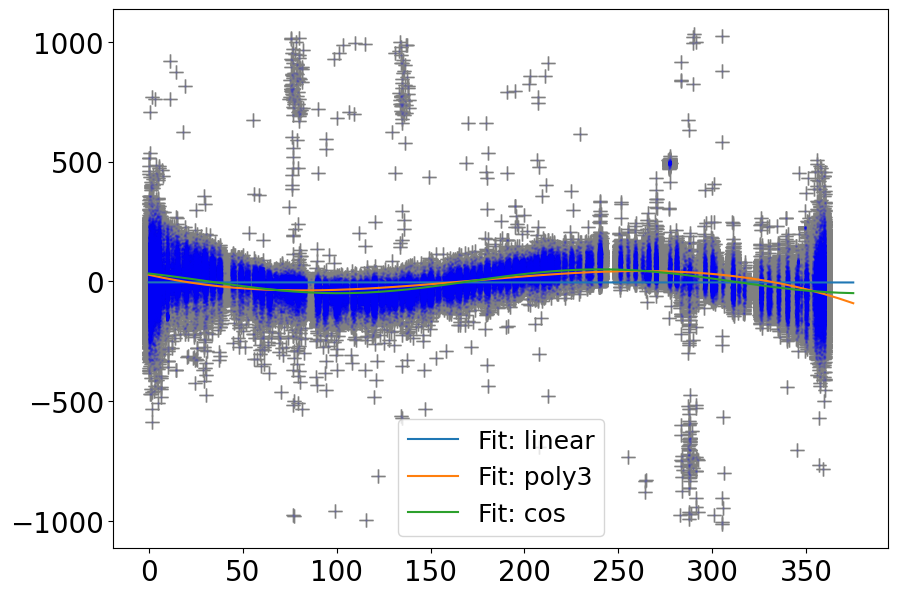

1. The cosine and poly3 function both worked pretty well for this one.
2. For the poly3 function, larger numbers made it work pretty well, but for the cosine function I had a 15, a 25, and a 0.01.


In [74]:
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolean Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct5 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      (star['GLAT'] < 10) & \
      (star['GLAT'] > -10) & \
      np.isfinite(star['GLON']) &\
      np.isfinite(star['VHELIO_AVG']) & np.isfinite(star['VERR'])
cut5 = np.where(ct5)[0]

#=================================================================================
## LINEAR FIT (2 parameter)
slope5, intercept5 = mcFit2(linear, star['GLON'][cut5], star['VHELIO_AVG'][cut5] ,0.0001 , \
                          star['VERR'][cut5], p0=[20,10])
print(f'LINEAR: {slope5:.3f}, {intercept5:.3f}')


#=================================================================================
#COS FIT (4 parameter)
cfA5, cfB5, cfC5, cfD5 = mcFit4(cosfit, star['GLON'][cut5], star['VHELIO_AVG'][cut5], 0.0001, \
                            star['VERR'][cut5],p0=[25,0.01,15,0])
print(f'COSFIT: {cfA5:.3f}, {cfB5:.3f}, {cfC5:.3f}, {cfD5:.3f}')
#=================================================================================
#Poly 3 fit
threeA5, threeB5, threeC5, threeD5 = mcFit4(poly3, star['GLON'][cut5], star['VHELIO_AVG'][cut5], 0.0001, star['VERR'][cut5], p0 = [50, 100, 10, 100])
print(f'POLY3: {threeA5: .3f}, {threeB5: .3f}, {threeC5: .3f}, {threeD5: .3f}')



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig5 = plt.figure(figsize=(10,7))
ax5 = fig5.add_subplot(111)
ax5.xaxis.set_tick_params(labelsize=20)
ax5.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax5.scatter(star['GLON'][cut5],star['VHELIO_AVG'][cut5],s=1,c='b',alpha=0.1)
ax5.errorbar((star['GLON'][cut5]),star['VHELIO_AVG'][cut5], 'GLON'==(0.1),
             'VERR'==(0.1), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot5 = np.linspace(0,375,50) # X-PLOTING FOR FITS
#x_scaled4 = x_plot4/1000

#=================================================================================
#linear fit
ax5.plot(x_plot5,linear(x_plot5, slope5, intercept5), label='Fit: linear')
#poly3 fit
ax5.plot(x_plot5,poly3(x_plot5, threeA5, threeB5, threeC5, threeD5), label='Fit: poly3')
#cos fit
ax5.plot(x_plot5,cosfit(x_plot5, cfA5, cfB5, cfC5, cfD5), label='Fit: cos')

plt.legend(loc='best', fontsize=18)
plt.show()

print('1. The cosine and poly3 function both worked pretty well for this one.')
print('2. For the poly3 function, larger numbers made it work pretty well, but for the cosine function I had a 15, a 25, and a 0.01.')

## DATA FIT 6

Fit  a linear and a polynomial (poly2 AND poly3) functions and to the following selections of the data:
7. __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  NI\_FE (NI\_FE\_ERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: 0.013, 0.016
POLY2: 0.003, -0.003, 0.009
POLY3: -0.021, -0.019,  0.026,  0.018


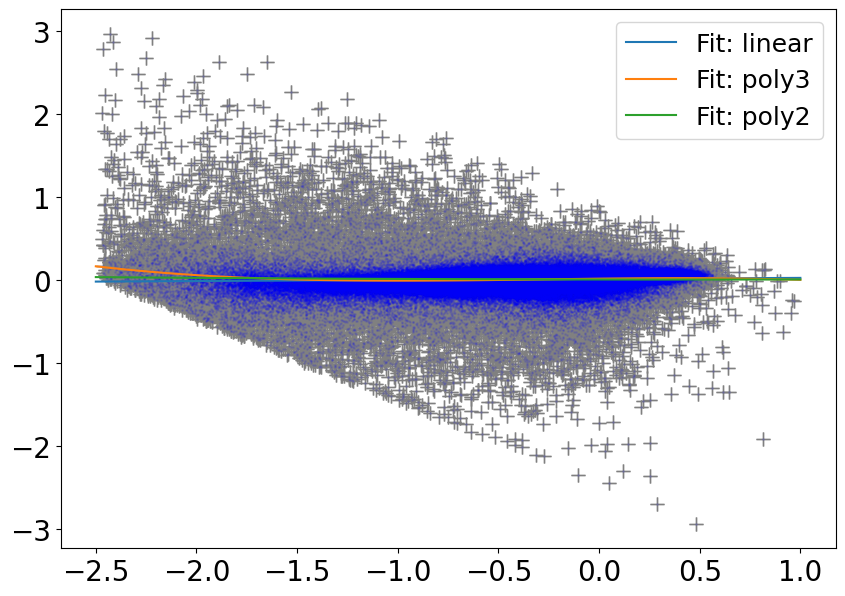

1. This function is pretty straightfordward and all the functions fit it pretty well.
2. I mostly used 10s and 1s for this one.


In [75]:
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolean Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct6 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      np.isfinite(star['FE_H']) & np.isfinite(star['FE_H_ERR']) & \
      np.isfinite(star['NI_FE']) & np.isfinite(star['NI_FE_ERR'])
      
cut6 = np.where(ct6)[0]

#=================================================================================
## LINEAR FIT (2 parameter)
slope6, intercept6 = mcFit2(linear, star['FE_H'][cut6], star['NI_FE'][cut6] , star['FE_H_ERR'][cut6] , \
                          star['NI_FE_ERR'][cut6], p0=[20,10])
print(f'LINEAR: {slope6:.3f}, {intercept6:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
polyA6, polyB6, polyC6,  = mcFit3(poly2, (star['FE_H'][cut6]), star['FE_H_ERR'][cut6], star['NI_FE'][cut6], \
                         star['NI_FE_ERR'][cut6],p0=[6,1,1])
print(f'POLY2: {polyA6:.3f}, {polyB6:.3f}, {polyC6:.3f}')

#=================================================================================
#COS FIT (4 parameter)
#cfA5, cfB5, cfC5, cfD5 = mcFit4(cosfit, star['GLON'][cut5], star['VHELIO_AVG'][cut5], 0.001, \
                            #star['VERR'][cut5],p0=[200,10,20,20])
#print(f'COSFIT: {cfA5:.3f}, {cfB5:.3f}, {cfC5:.3f}, {cfD5:.3f}')
#=================================================================================
#Poly 3 fit
threeA6, threeB6, threeC6, threeD6 = mcFit4(poly3, star['FE_H'][cut6], star['NI_FE'][cut6], star['FE_H_ERR'][cut6], star['NI_FE_ERR'][cut6], p0 = [50, 10, 10, 10])
print(f'POLY3: {threeA6: .3f}, {threeB6: .3f}, {threeC6: .3f}, {threeD6: .3f}')

#===================================================================================
#exponential fit
#exA4, exB4, exC4, exD4 = mcFit4(exponential, TEFF_scaled, (JK), TEFF_ERR_scaled, JK_ERR, p0 = [.5, -0.2, 0.1, 0.5], bounds = bounds, maxfev = 20000)
#print(f'EXPONENTIAL: {exA4: .3f}, {exB4: .3f}, {exC4: .3f}, {exD4: .3f}')


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig6 = plt.figure(figsize=(10,7))
ax6 = fig6.add_subplot(111)
ax6.xaxis.set_tick_params(labelsize=20)
ax6.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax6.scatter(star['FE_H'][cut6],star['NI_FE'][cut6],s=1,c='b',alpha=0.1)
ax6.errorbar((star['FE_H'][cut6]),star['NI_FE'][cut6], 'FE_H_ERR'==(0.1),
             'NI_FE_ERR'==(0.1), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot6 = np.linspace(-2.5,1,50) # X-PLOTING FOR FITS
#x_scaled4 = x_plot4/1000

#=================================================================================
#linear fit
ax6.plot(x_plot6,linear(x_plot6, slope6, intercept6), label='Fit: linear')
#poly3 fit
ax6.plot(x_plot6,poly3(x_plot6, threeA6, threeB6, threeC6, threeD6), label='Fit: poly3')
#poly2 fit
ax6.plot(x_plot6,poly2(x_plot6, polyA6, polyB6, polyC6), label='Fit: poly2')

plt.legend(loc='best', fontsize=18)
plt.show()

print("1. This function is pretty straightfordward and all the functions fit it pretty well.")
print('2. I mostly used 10s and 1s for this one.')